# Digit Recognition System
Neural Network for recognizing digits written by hand. This is done more or less from scratch, not using all of PyTorch functionalities, instead it is only used for operating tensors. Everything else is done by hand, to actually show how a network is implemented.

In [1]:
# Import libraries
import torch
import numpy as np
import sys
from timeit import default_timer as timer
import matplotlib.pyplot as plt

## Activation functions
Firstly the activation functions for the hidden and output layers are defined. These act between the different layers of the neural network.

In [161]:
# Sigmoid function
def sig(T, gradient=False):
  if gradient:
    sigT = sig(T)
    return sigT * (1 - sigT)
  return torch.reciprocal(1 + torch.exp(-1 * T))

# Rectified Linear Unit function
def relu(T, gradient=False):
  if gradient:
    outT = torch.zeros_like(T)
    outT[T>=0] = 1
    return outT
  return torch.max(T, torch.zeros_like(T))

# Softmax function
def softmax(T, dim, estable=True):
  if estable:
    T -= T.max(dim=dim, keepdim=True)[0]
  exp = torch.exp(T)
  return exp / torch.sum(exp, dim=dim, keepdim=True)

## Loss function
For this network, the loss function will be defined by the cross-entropy, which, for two discrete probability distributions $p(x)$ and $q(x)$, is as follows

\begin{equation}
\it{CE}(p,q)=\sum_{x}p(x)\log \bigg(\frac{1}{q(x)}\bigg)=- \sum_{x}p(x)\log q(x)
\end{equation}

Then, the loss function `CELoss` receives two tensors $Q_{ij}$ y $P_{ij}$ and calculates the mean of the cross-entropy of the distributions $p_i$ y $q_i$.
\begin{equation}
\it{CELoss}(Q,P)=\frac{1}{N}\sum_{i}\it{CE}(p_{i}, q_{i})
\end{equation}
where $p_i(x)=P_{ix}$, $q_i(x)=Q_{ix}$ and $N$ is the length of the first dimension of the tensors. 

Due to the limitations of computational power, sometimes the `log` function may return `NaN` when the probability is too low. For that, an epsilon is used for limiting the minimum value when `estable=True`.


In [162]:
# Cross-entropy Loss function
def CELoss(Q, P, estable=True, epsilon=1e-8):
  N = Q.shape[0]
  if estable:
    Q = Q.clamp(epsilon, 1-epsilon)
  return -(P * Q.log()).sum()/N

## Neural Network
For resolving this problem, a Feed Forward Neural Network will be implemented as a class. This class, named `FFNN`, will be built as a subclass of [`torch.nn.Module`](https://pytorch.org/docs/stable/nn.html#torch.nn.Module), receiving the following parameters for initializing:

*   `F`: Number of neurons in the input layer
*   `l_h`: List of number of neurons in each of the hidden layers
*   `l_a`: List of the activation functions
*   `C`: Number of neurons in the output layer
*   `l_a_params`: List of parameters for the activation functions, if any

Also, it will have the methods for implemeting the forward and backward propagations, aptly named `forward` and `backward`.

In [163]:
# Additional imports for implementing the network
import torch.nn as nn
from torch.nn import Parameter, ParameterList

# A function for creating the random initial weights for the network
def get_init_weights(shape):
  W = torch.randn(shape)
  return Parameter(W)

In [164]:
# The main class for the neural network
class FFNN(nn.Module):
  # Constructor of the class, with it's parameters
  def __init__(self, F, l_h, l_a, C, l_a_params=None):
    super(FFNN, self).__init__()

    sizes = [F] + l_h + [C]   # All layers' sizes are concatanated into one list
    # The weights and biases are stored as parameters of the class. Weights are randomized with get_init_weights and biases are zero
    self.Ws = ParameterList([get_init_weights((sizes[i], sizes[i+1])) for i in range(len(sizes)-1)])
    self.bs = ParameterList([Parameter(torch.zeros(h)) for h in sizes[1:]])
    # The activation functions are stored
    self.fs = l_a
    # The activation functions' parameters are stored, if any.
    # In this notebook they are not used, but it is still implemented for good practice
    if l_a_params is not None:
      self.fs_ps_mask = [Parameter(torch.tensor(p)) if p else None for p in l_a_params]
    else:
      self.fs_ps_mask = [None for _ in l_a]

  # Method for loading weights and biases into the network by hand
  # It is not used in this notebook but it is still a useful function
  def load_parameters(self, Ws, U, bs, c):
    self.Ws = ParameterList([Parameter(W) for W in Ws + [U]])
    self.bs = ParameterList([Parameter(b) for b in bs + [c]])
  
  # The forward propagation of the network.
  # The input x goes through the layers of the network, and the return value 
  # is the softmax of the output layer, to get the probabilities of the class predictions.
  def forward(self, x):
    self.cacheU = [] 
    for W, b, f, p in zip(self.Ws[:-1], self.bs[:-1], self.fs, self.fs_ps_mask):
      x = torch.mm(x, W) + b
      self.cacheU.append(x) # A cache is used for storing the input values of the layers, to be later used by the backward propagation
      x = f(x, p.item()) if p else f(x)
    return softmax(torch.mm(x, self.Ws[-1]) + self.bs[-1], dim=1)
  
  # The backward propagation of the network, for training.
  # Computes the gradients for each parameter of the network, using the x input,
  # the real y values, and the predicted y values.
  def backward(self, x, y, y_pred):
    current_grad = (y_pred - y) / y.size(0)
    
    for i in range(len(self.Ws)-1, 0, -1):
      if self.fs_ps_mask[i-1] is None:
        # Activation function without parameter
        self.Ws[i].grad = self.fs[i-1](self.cacheU[i-1]).t() @ current_grad
      else:
        # Activation function with parameter
        self.Ws[i].grad = self.fs[i-1](self.cacheU[i-1], self.fs_ps_mask[i-1].item()).t() @ current_grad
      self.bs[i].grad = current_grad.sum(dim=0)
      h_grad = current_grad @ self.Ws[i].t()
      
      if self.fs_ps_mask[i-1] is None:
        # Activation function without parameter
        current_grad = self.fs[i-1](self.cacheU[i-1], gradient=True) * h_grad
      else:
        # Activation function with parameter
        current_grad, p_grad = self.fs[i-1](self.cacheU[i-1], self.fs_ps_mask[i-1], gradient=True)
        current_grad *= h_grad
        self.fs_ps_mask[i-1].grad = (p_grad * h_grad).sum()
    
    self.Ws[0].grad = x.t() @ current_grad
    self.bs[0].grad = current_grad.sum(dim=0)

## Stochastic gradient descent
A class will be implemented, named `SGD`, that computes the gradient descent algorithm. This is done for optimizing the network. It receives the `parameters` to which the gradient descent will be applied, the learning rate `lr` for it and the `weight_decay` for regularizing the parameters.

In [166]:
# The class that implements the stochastic gradient descent algorithm
class SGD():
  # Constructor of the class
  def __init__(self, parameters, lr, weight_decay=0):
    self.wd = 1.0 - weight_decay
    self.lr = lr
    
    # Regularize the size of the weights of some parameters
    if self.wd:
      self.w_params, self.params = [], []
      for p in parameters:
        (self.w_params if len(p.size()) == 2 else self.params).append(p)
    else:
      self.params = [p for p in parameters]
  
  # Method for updating the parameters, with the learning rate and weight decay associated
  def step(self):
    for p in self.params:
      p.data -= p.grad * self.lr
    if self.wd:
      for p in self.w_params:
        p.data = self.wd * p.data - p.grad * self.lr

## Training the network
The loop for training the network is implemented next. The function receives the network, a dataset, an optimizer, number of epochs for training, package size of the training examples and the device where the loop will be executed.

The function iterates the indicated number of epochs, and it returns a list for the loss and the accuracy for each iteration.

In [167]:
# Additional libraries that will be useful
from torch.utils.data import Dataset, DataLoader

# Function for the training loop of a network
def train_FFNN(network, dataset, optimizer, epochs=1, batch_size=1, reports_every=1, device='cuda'):
  network.to(device)    # Change the network to the correct device

  # Get the data from the provided dataset
  data = DataLoader(dataset, batch_size, shuffle=True)
  total=len(dataset)
  time_epochs = 0
  loss, acc = [], []
  # Iterate the number of epochs
  for e in range(1,epochs+1):  
    epoch_start = timer()   # For calculating the time for each epoch
    
    # Go through the data
    for x, y in data:
      # Reshape as needed
      x, y = x.view(x.size(0), -1).float().to(device), y.to(device)
      
      y_pred = network(x)   # Input goes through the network
      
      # Creates a one-hot shaped like the predicted value,
      # so the network can make the backward propagation
      # with tensors of same shape
      y_onehot = torch.zeros_like(y_pred)
      y_onehot[torch.arange(x.size(0)), y] = 1.
    
      network.backward(x, y_onehot, y_pred) # Backward propagation

      optimizer.step() # Update the parameters using the provided optimizer
    
    time_epochs += timer() - epoch_start
    
    # For reporting the performance of the network every reports_every epochs
    if e % reports_every == 0:
      # Same process as before
      X = dataset.data.view(len(dataset), -1).float().to(device)
      Y = dataset.targets.to(device)
      
      Y_PRED = network.forward(X).to(device)
      
      Y_onehot = torch.zeros_like(Y_PRED)
      Y_onehot[torch.arange(X.size(0)), Y] = 1.

      # Calculate the cross-entropy loss and append it to the list
      L_total = CELoss(Y_PRED, Y_onehot)
      loss.append(L_total.item())
      diff = Y-torch.argmax(Y_PRED,1)
      errors = torch.nonzero(diff).size(0)

      # Calculate the accuracy of the model for this epoch and append it to the list
      Acc=100*(total-errors)/total
      acc.append(Acc)

      # For writing on screen how well it is doing
      sys.stdout.write(
            '\rEpoch:{0:03d}'.format(e) + ' Acc:{0:.2f}%'.format(Acc)
            + ' Loss:{0:.4f}'.format(L_total) 
            + ' Tiempo/epoch:{0:.3f}s'.format(time_epochs/e))
  
  # Returns the list with the loss and accuracy for each epoch
  return loss, acc

## MNIST dataset
Now is finally time for importing the MNIST dataset and train a model for it.

In [168]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

# Downloads and stores the MNIST train dataset
mnist_dataset = MNIST('mnist', train=True, transform=ToTensor(), download=True)

In [169]:
# The network is defined, followed by it's optimizer
mnist_model = FFNN(784, [256,128,64], [relu, sig, relu], 10)
mnist_optimizer = SGD(mnist_model.parameters(), lr=1e-2, weight_decay=2e-5)

epoch_n = 50 # Number of epochs to train the network for

# The training is done, reporting every epoch
with torch.no_grad():
  mnist_loss, mnist_acc = train_FFNN(mnist_model, mnist_dataset, mnist_optimizer, epochs=epoch_n, batch_size=32)

Epoch:050 Acc:96.23% Loss:0.1206 Tiempo/epoch:6.261ss

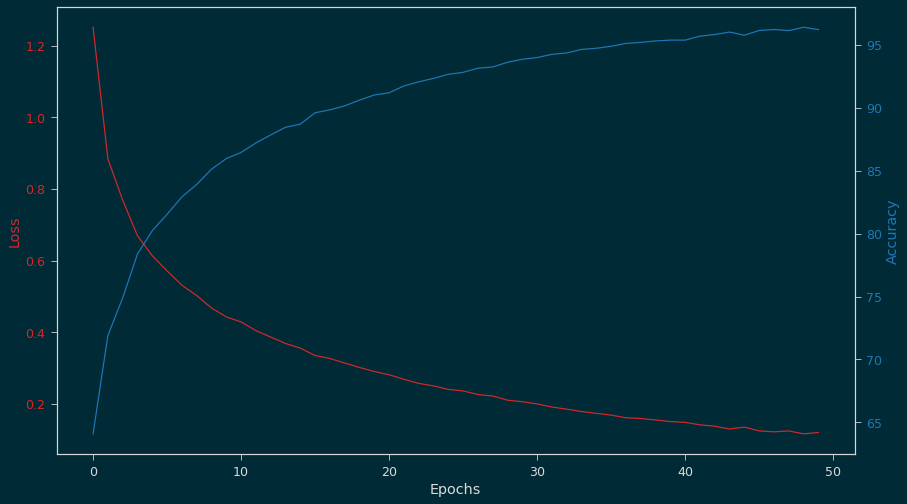

In [174]:
# The loss and accuracy for each epoch are plotted
epoch_plot = np.arange(0, epoch_n)
fig, loss_plot = plt.subplots()

color = 'tab:red'
loss_plot.set_xlabel('Epochs')
loss_plot.set_ylabel('Loss', color=color)
loss_plot.plot(epoch_plot, mnist_loss, color=color)
loss_plot.tick_params(axis='y', labelcolor=color)

acc_plot = loss_plot.twinx()
color = 'tab:blue'
acc_plot.set_ylabel('Accuracy', color=color)
acc_plot.plot(epoch_plot, mnist_acc, color=color)
acc_plot.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

## Results
With the trained model, now it will be tested with a different dataset than the one used for training. After that, some metrics will be calculated to observe the performance of the model.

In [175]:
from random import randint
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassConfusionMatrix, MulticlassF1Score
import seaborn as sns

# Test a model with a test dataset
def test_model(model, dataset, n_examples=0, device='cuda'):
  # Go through all dataset
  if (n_examples==0):
    total = len(dataset)
    # Get data from dataset
    input = dataset.data.view(total, -1).float().to(device)
    targets = dataset.targets.to(device)
    # Pass through the model to get predictions
    predicted = model(input).to(device)
    return predicted, targets

  # Test n random examples and print each result
  fig, axs = plt.subplots(ncols=n_examples, figsize=(n_examples*3, 4), constrained_layout=True)
  # For each example, see the predicted value and the real value 
  for i in range(n_examples):
    idx = randint(0,len(dataset))
    T, l = dataset[idx]
    img = T.view(28,28).numpy()
    pred_prob, pred_label = torch.max(model(T.to('cuda').view(1, 784)), dim=1)
    axs[i].set_title("class: {}\nprediction: {}\nprob: {:.2f}".format(l, pred_label.item(), pred_prob.item()))
    axs[i].imshow(img)
  fig.suptitle('Visual examples', fontsize=20)


# Get the metrics of the performance of a model, comparing the predicted and real values
def get_metrics(predicted, targets, metrics, labels, device='cuda'):
    Results = {}
    # Get the metrics and print
    for i in range(len(metrics)):
        metric = metrics[i](num_classes=10).to(device)
        result = metric(predicted, targets).item()
        Results[labels[i]] = result
    return Results

# Plot the confusion matrix of a model
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    fig, ax = plt.subplots(figsize=(16, 14))
    sns.heatmap(cm, annot=True, ax = ax, fmt = 'g')
    ax.set_xlabel('Predicted', fontsize=20)
    ax.xaxis.set_ticklabels(classes, fontsize = 15)
    ax.set_ylabel('True', fontsize=20)
    ax.yaxis.set_ticklabels(classes, fontsize = 15)
    plt.yticks(rotation=0)
    plt.title(title, fontsize=20)

Accuracy: 0.951577
Precision: 0.953080
Recall: 0.951577
F1Score: 0.952039


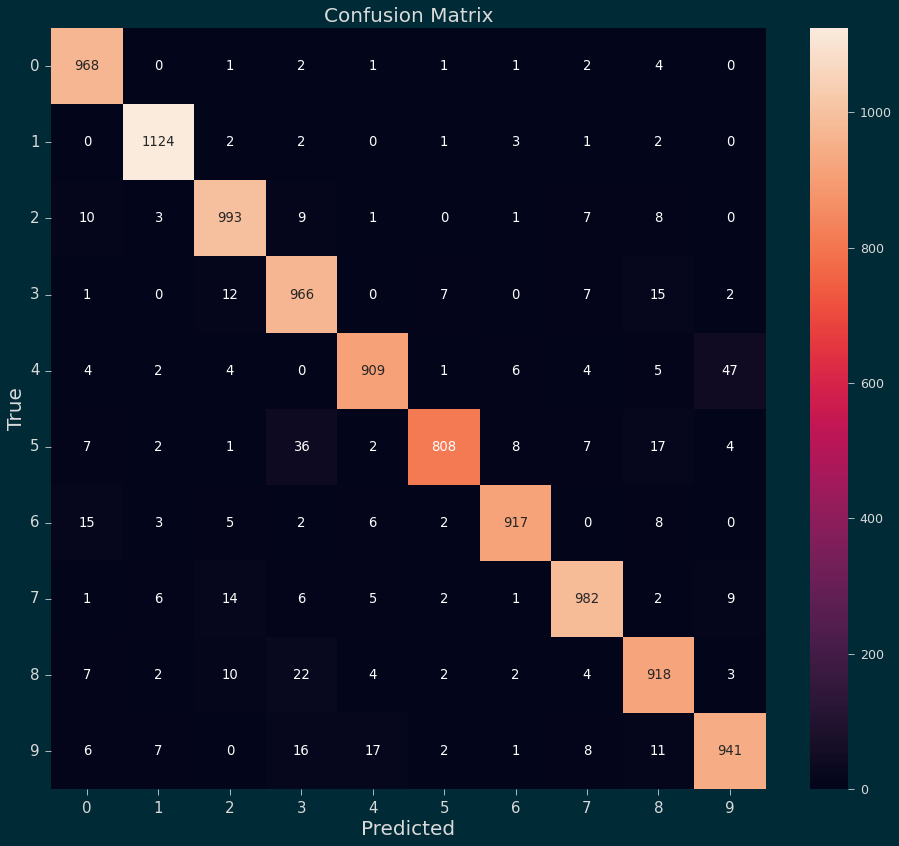

In [176]:
# Download MNIST test dataset
mnist_test_dataset = MNIST('mnist', train=False, transform=ToTensor(), download=True)

# Test the model and get values
predicted, targets = test_model(mnist_model, mnist_test_dataset)

# Compute metrics, taking the average for all classes
metrics = [MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassF1Score]
labels = ['Accuracy', 'Precision', 'Recall', 'F1Score']
metric_results = get_metrics(predicted, targets, metrics, labels)
for i in metric_results:
  print(i+':', '{:.6f}'.format(metric_results[i]))

# Calculate the confusion matrix
cm_metric = MulticlassConfusionMatrix(num_classes=10).to('cuda')
cm = cm_metric(predicted, targets).tolist()
class_names = list(range(0,10))
plot_confusion_matrix(cm, class_names)


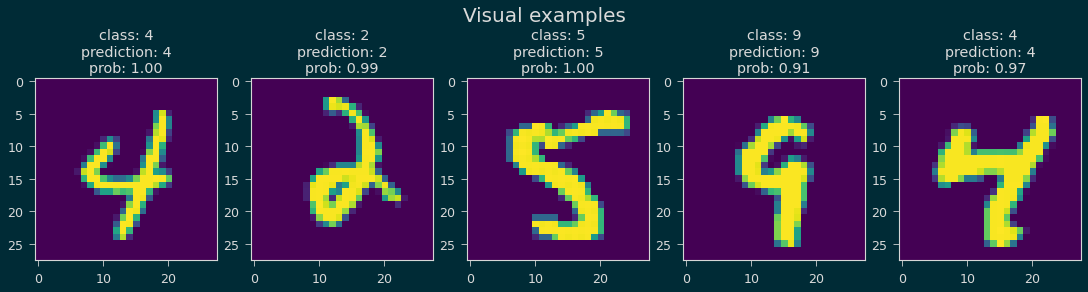

In [191]:
# Visual Test
test_model(mnist_model, mnist_test_dataset, n_examples=5)

## Conclusion
The metrics show that the performance of the model is outstanding against the testing dataset. It classifies the inputs really well, with high probabilities of choosing the correct answer. This can not only be observed by numbers, but also graphically in the confusion matrix, where the difference between the correctly labeled and the incorrect ones is astounding. Finally, taking five random tests, it can be seen that most of the time the classification is done with high confidence in that label when chossing it.